这一章比较不同对流层校正方法效果的不同。

注意ERA5与wrf中相似含义（如温度）的量其实具有较大差别，所以处理wrf的源码不能直接搬到这里处理ERA5。

In [24]:
import sys
sys.path.append("..")
import os
os.chdir("..")
from functions.dem import wgs2utm, utm2wgs,Coord, Egm, SRTM
from functions.image import TX,wgs2ecs
from functions.wrf import Wrf
from functions.trans import cos_vectors
from sklearn.linear_model import LinearRegression
from tifffile import TiffFile
import pandas as pd
import xarray as xr
import numpy as np
from glob import glob
import re
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 14})


In [39]:
era5_dir = "data/era5"
zpd_dir = "data/bjfs"
egm96_path = "data/EGM/EGM96.tif"
bjfs_srtm = "data/SRTM/SRTMGL1/N39E115.hgt"
srtm_path = "data/SRTM/SRTMGL1/N40E116.hgt"
sDay = "20190117"
wrf_path = glob("data/wrf/wrfout_d01_%s-%s-%s*" % (sDay[:4], sDay[4:6], sDay[6:8]))[0]
gacos_path = "data/gacos/%s.ztd.tif" % sDay
def get_tx_paths():
    xml_paths = glob(
        "data/TerraSAR-X/*/TSX-1.SAR.L1B/*/*SAR__SSC*.xml")
    res = {}
    for i in xml_paths:
        filename = i.split("/")[-1][:-4]
        res[filename[28:36]] = ((i, glob(
            "data/TerraSAR-X/*/TSX-1.SAR.L1B/%s/IMAGEDATA/*.cos" % filename)[0]))
    return res

首先是验证Era5数据的准确性

In [9]:
def read_grib(path):
    # isobaricInhPa, time, latitude, longitude
    # z: geopotential
    # r: relative_humidity
    # q: specific_humidity
    # t: air_temperature
    # u: eastward_wind
    # v: northward_wind
    data = xr.open_dataset(path)
    res = {}
    res['p'] = np.array(data['isobaricInhPa']).reshape((1,-1,1,1))
    res['h'] = np.array(data['z']) / 9.80665
    qvapor = np.array(data['q'])
    res['vapor_pressure'] = res['p'] / (1 + 0.622 / qvapor)
    res['t'] = np.array(data['t'])
    res['lat'] = float(data['latitude'][0])
    res['lon'] = float(data['longitude'][0])
    return res


class Era5(object):
    def __init__(self, srtm):
        data = [read_grib(os.path.join(era5_dir, "%d.grib" % i)) for i in range(1, 4)]
        self.p = data[0]['p']
        self.h = np.concat([i['h'] for i in data], axis=0)
        self.vapor_pressure = np.concat([i['vapor_pressure'] for i in data], axis=0)
        self.t = np.concat([i['t'] for i in data], axis=0)
        lat, lon = data[0]['lat'], data[0]['lon']
        self.base_height = srtm.find(np.array([lon]), np.array([lat]), Coord.WGS84)[0]

    def delay(self, doy):
        time_index = doy * 3 - 2
        p = self.p[0, :, 0, 0]
        h = self.h[time_index - 1, :, 0, 0]
        vapor_pressure = self.vapor_pressure[time_index - 1, :, 0, 0]
        t = self.t[time_index - 1, :, 0, 0]

        dry_pressure = p - vapor_pressure
        k1, k2, k3 = 77.6, 71.6, 3.75e5
        N_dry = k1 * dry_pressure / t
        N_wet = k2 * vapor_pressure / t + k3 * vapor_pressure / t**2
        N = N_dry + N_wet
        offset = 1e-6*(k1*287.05*np.mean(p[-1])/9.81)

        h = (h[1:] + h[:-1]) / 2
        height = self.base_height
        res = 0
        for i in range(len(h)):
            if h[i] > height:
                res += (h[i] - height) * N[i]
            height = h[i]
        res = res * 1e-6 + offset
        return res


class Zpd(object):
    def __init__(self) -> None:
        files = sorted(glob(os.path.join(zpd_dir, "*")))
        res = [[], []]
        for i in files:
            with open(i, "r") as f:
                data = re.search(r"19:(\d{3}):36000 ([0-9.]*?) ", f.read())
                doy = int(data.group(1))
                delay = float(data.group(2))/1000
                res[0].append(doy)
                res[1].append(delay)
        self.data = res


    def __call__(self):
        return self.data

/tmp/ipykernel_17003/926167485.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  res['p'] = np.array(data['isobaricInhPa']).reshape((1,-1,1,1))
/tmp/ipykernel_17003/926167485.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  res['h'] = np.array(data['z']) / 9.80665
/tmp/ipykernel_17003/926167485.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  qvapor = np.array(data['q'])
/tmp/ipykernel_17003/926167485.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  res['t'] = np.array(data['t'])


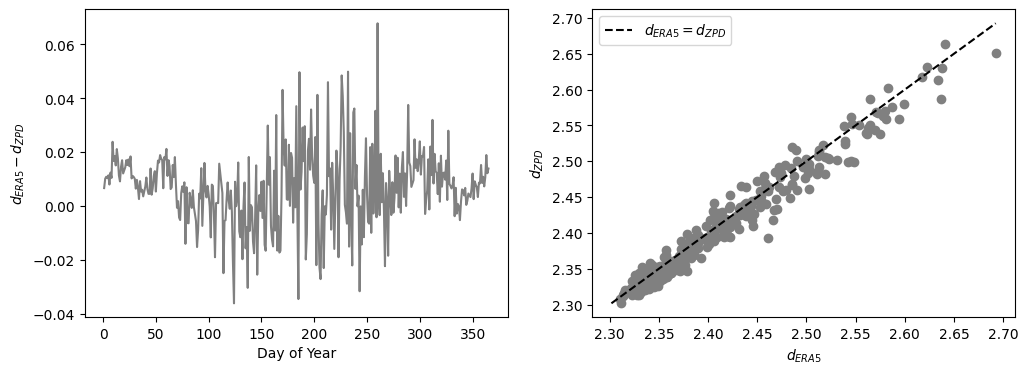

In [13]:
def plot(zpd, era5):
    y_zpd = zpd[1]
    y_era5 = np.array([era5.delay(i) for i in zpd[0]])
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(zpd[0], y_era5 - y_zpd, c="gray")
    plt.xlabel("Day of Year")
    plt.ylabel("$d_{ERA5}-d_{ZPD}$")

    plt.subplot(1,2,2)
    plt.scatter(y_era5, y_zpd, c='gray')
    p1 = np.min(np.concat([y_zpd, y_era5]))
    p2 = np.max(np.concat([y_zpd, y_era5]))
    plt.plot((p1, p2), (p1, p2), label="$d_{ERA5} = d_{ZPD}$", c='black', linestyle="--")
    plt.legend()
    plt.xlabel("$d_{ERA5}$")
    plt.ylabel("$d_{ZPD}$")
    plt.show()


srtm = SRTM(bjfs_srtm, Egm(egm96_path))
era5 = Era5(srtm)
zpd = Zpd()()
plot(zpd, era5)

然后是比较ray tracing和zenith delay map两种方法

In [29]:
def get_pos():
    xml_path, cos_path = get_tx_paths()[sDay]
    x, y = wgs2utm(116.28, 40.25)
    xs, ys = np.meshgrid(x+np.arange(-10e3,10e3, 90), y+np.arange(-10e3,10e3, 90))
    lons, lats = utm2wgs(xs, ys)
    hs = SRTM(srtm_path, Egm(egm96_path)).find(lons, lats,Coord.WGS84)
    tx = TX(xml_path, cos_path)
    gen = tx.indirect_with_offset(lons, lats, hs)
    sp = gen.send(None)
    return lons, lats, hs, sp

def ray_tracing(lons, lats, hs, sp):
    res, cos_zenith, cons = Wrf(wrf_path).cal_delays(sp, lons, lats, hs)
    return (res + cons) / cos_zenith

def zenith_N(lons, lats):
    w = Wrf(wrf_path)
    h = w.get_params(w.h, lons, lats)
    N = w.get_params(w.N, lons, lats)
    return N, h, w.offset

def zenith_delay_mapping(lons, lats, hs, sp):
    tp = wgs2ecs(lons, lats, hs)
    cos_zenith = cos_vectors(tp, sp - tp)
    N, h, offset = zenith_N(lons, lats)
    return (1e-6 * np.sum(np.multiply(h[1:]-h[:-1], N), axis=0) + offset) / cos_zenith

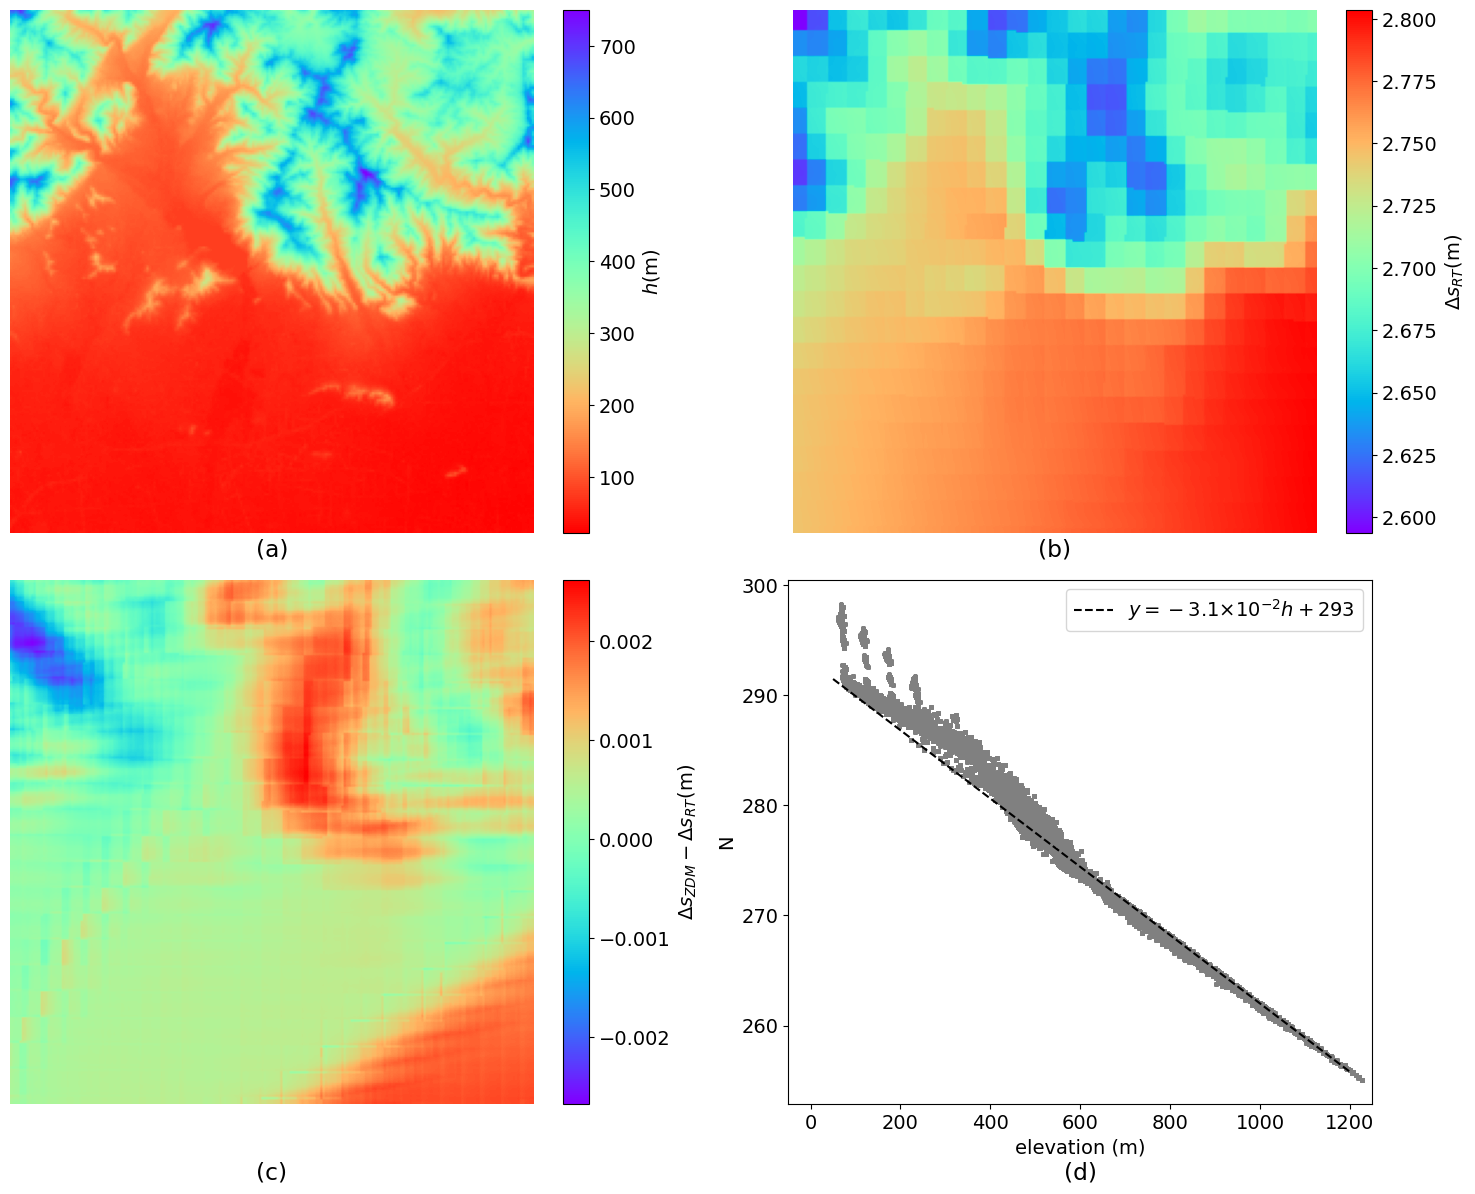

In [37]:
def rt_vs_zdm():
    lons, lats, hs, sp = get_pos()
    rt = ray_tracing(lons, lats, hs, sp)
    zdm = zenith_delay_mapping(lons, lats, hs, sp)
    N, h, _ = zenith_N(lons, lats)
    N = N[:10]
    h = ((h[1:] + h[:-1]) / 2)[:10]

    plt.figure(figsize=(15,12))
    barHeight = 0.045
    plt.subplot(2,2,1)
    plt.imshow(hs, origin="lower",cmap="rainbow_r")
    plt.colorbar(fraction=barHeight).set_label("$h$(m)")
    plt.axis("off")
    plt.title("(a)", y=-0.06)
    plt.subplot(2,2,2)
    plt.imshow(rt,origin = 'lower',cmap="rainbow")
    plt.colorbar(fraction=barHeight).set_label("$Δs_{RT}$(m)")
    plt.axis("off")
    plt.title("(b)", y=-0.06)
    plt.subplot(2,2,3)
    plt.imshow(zdm - rt,origin = 'lower',cmap="rainbow")
    plt.colorbar(fraction=barHeight).set_label("$Δs_{ZDM}-Δs_{RT}$(m)")
    plt.axis("off")
    plt.title("(c)", y=-0.16)
    plt.subplot(2,2,4)
    # reg = LinearRegression().fit(np.reshape(h,(-1,1)),np.reshape(N,(-1,1)))
    # k, b = reg.coef_.ravel(), reg.intercept_.ravel()[0]
    k, b = -3.1e-2, 293
    plt.scatter(x=h.ravel(), y=N.ravel(), c="gray", s=5)
    plt.plot((50, 1200), list(map(lambda x: k*x+b, (50, 1200))), label="$y=%.1f×10^{-2}h+%d$"%(k * 100, b), c="black", linestyle="--")
    plt.xlim(-50, 1250)
    plt.xlabel("elevation (m)")
    plt.ylabel("N")
    plt.legend()
    plt.title("(d)", y=-0.16)
    plt.tight_layout()
    plt.show()

rt_vs_zdm()

然后是基于wrf和gacos的ZDM方法比较

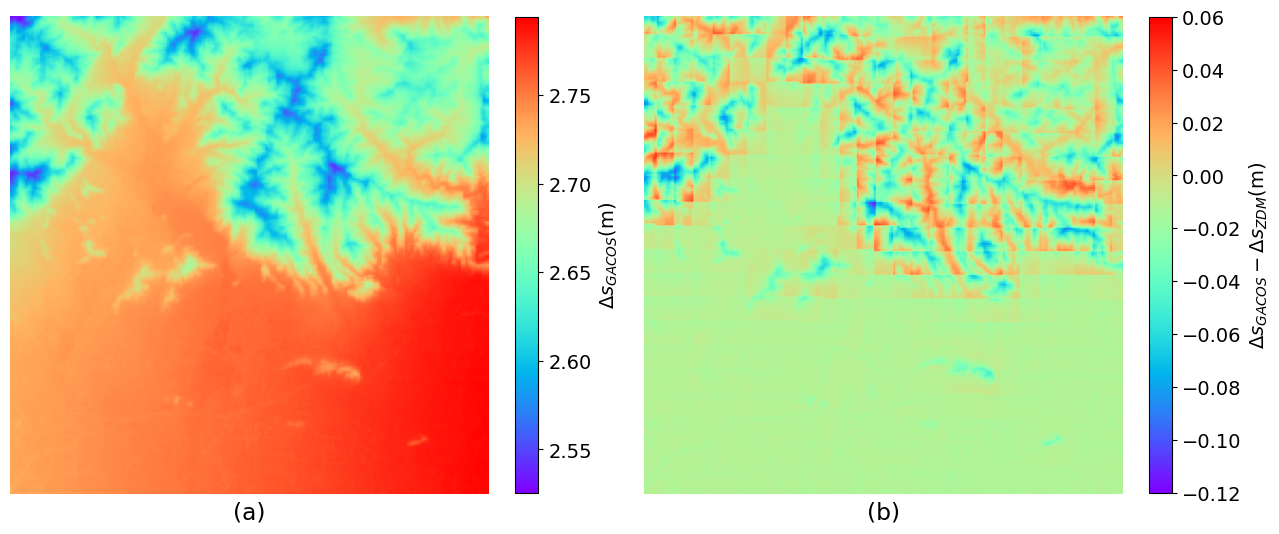

In [40]:
def gacos(lons, lats, hs, sp):
    tp = wgs2ecs(lons, lats, hs)
    cos_zenith = cos_vectors(tp, sp - tp)
    with TiffFile(gacos_path) as img:
        _, _, _, left, top, _ = img.pages[0].tags.get(
            'ModelTiepointTag').value
        dx, dy, _ = img.pages[0].tags.get('ModelPixelScaleTag').value
        data = img.pages[0].asarray()
        top, left = top - dy / 2, left + dx / 2
        
        lat_is = np.int32(np.round((top - lats) / dy))
        lon_is = np.int32(np.round((lons - left) / dx))
        res = data[lat_is, lon_is]
        return res / cos_zenith

def compare_zdm_gacos():
    lons, lats, hs, sp = get_pos()
    w = zenith_delay_mapping(lons, lats, hs, sp)
    g = gacos(lons, lats, hs, sp)
    down, up = -0.12, 0.06
    barHeight = 0.045
    plt.rcParams.update({"font.size": 14})
    plt.figure(figsize=(15,12))

    plt.subplot(1,2,1)
    plt.imshow(g,origin = 'lower',cmap="rainbow")
    plt.colorbar(fraction=barHeight).set_label("$Δs_{GACOS}$(m)")
    plt.axis("off")
    plt.title("(a)", y=-0.07)

    plt.subplot(1,2,2)
    plt.imshow(g - w,origin = 'lower',cmap="rainbow",vmin=down, vmax=up)
    plt.colorbar(fraction=barHeight).set_label("$Δs_{GACOS}-Δs_{ZDM}$(m)")
    plt.axis("off")
    plt.title("(b)", y=-0.07)
    plt.show()

compare_zdm_gacos()

最后研究下延迟与高程的关系

/tmp/ipykernel_17003/4189180312.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(t, k*t+b,c="black",label="$Δs=%.2f×10^{-4}h+%.2f$"%(1e4 * k,b))


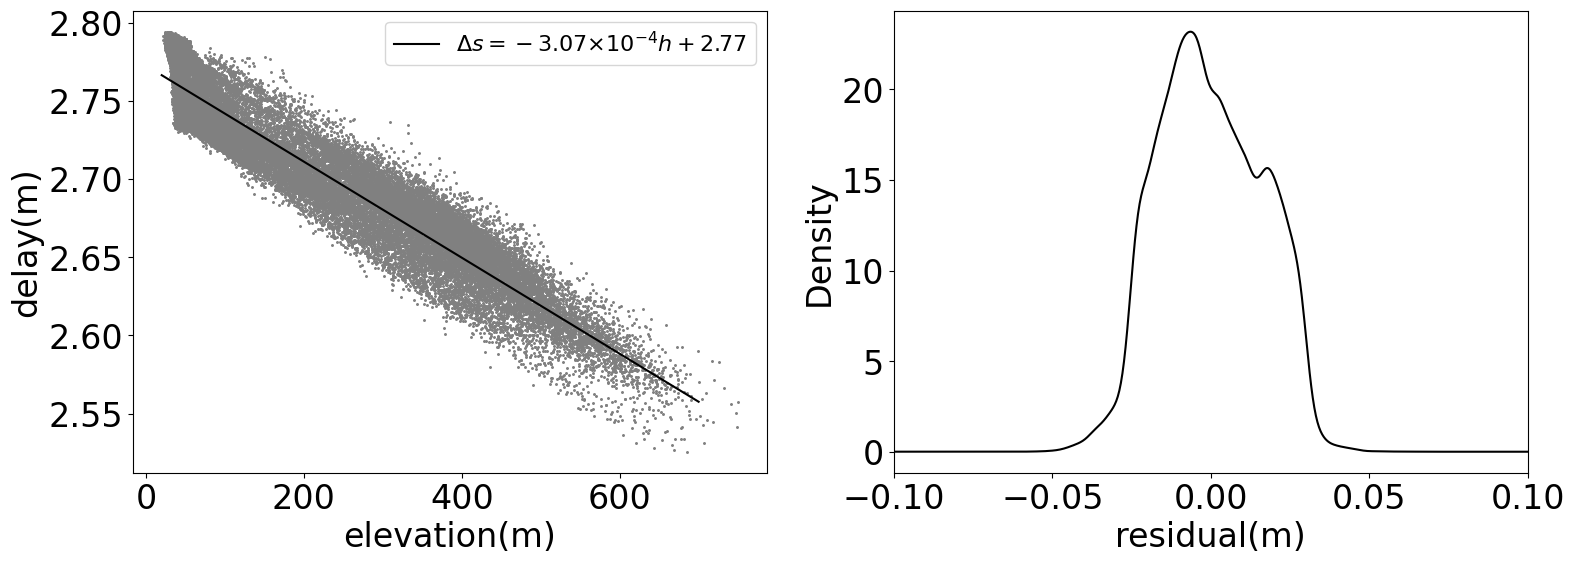

In [52]:
def delay_height():
    lons, lats, hs, sp = get_pos()
    # delay = zenith_delay_mapping(lons, lats, hs, sp)
    delay = gacos(lons, lats, hs, sp)
    reg = LinearRegression().fit(np.reshape(hs,(-1,1)),np.reshape(delay,(-1,1)))
    k, b = reg.coef_.ravel(), reg.intercept_.ravel()[0]
    t = np.array((20, 700))

    plt.figure(figsize=(18,6))
    plt.rcParams.update({"font.size": 24})
    plt.subplot(1,2,1)
    plt.scatter(hs, delay,marker='.', s=5,c="gray")
    plt.plot(t, k*t+b,c="black",label="$Δs=%.2f×10^{-4}h+%.2f$"%(1e4 * k,b))
    plt.xlabel("elevation(m)")
    plt.ylabel("delay(m)")
    plt.legend(fontsize=16)

    plt.subplot(1,2,2)
    pd.Series(np.sort(np.ravel(delay - k * hs - b))).plot(kind="kde",label="range",c="black", linestyle="solid")
    plt.xlabel("residual(m)")
    plt.xlim(-0.1, 0.1)
    plt.show()


delay_height()